# 🚀 Fraud Detection Reasoning Pipeline Demo

## Overview
This notebook demonstrates a comprehensive fraud detection pipeline that combines:
- **DistilBERT**: Fast and accurate fraud classification
- **GPT2-medium**: Detailed reasoning explanations (chosen based on LLM analysis)

## Model Selection Rationale
Based on the LLM comparison analysis:
- **GPT2-medium**: Best reasoning quality (4.9% score) with acceptable speed (0.26s)
- **DistilBERT**: Optimized for fast inference while maintaining accuracy

## Features
✅ Fast fraud classification  
✅ Detailed reasoning explanations  
✅ Fraud indicator analysis  
✅ Risk scoring  
✅ Interactive testing with sample cases  

In [8]:
# Install required packages if needed
!pip install torch transformers numpy pandas matplotlib seaborn -q

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,
    GPT2LMHeadModel, 
    GPT2Tokenizer
)
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📦 All packages imported successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"💾 Device available: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

📦 All packages imported successfully!
🔥 PyTorch version: 2.6.0+cu124
💾 Device available: cuda


## 🤖 Initialize the Fraud Reasoning Pipeline

In [9]:
class FraudReasoningPipeline:
    """
    Complete fraud detection pipeline with reasoning explanations
    """
    
    def __init__(self, 
                 distilbert_model_path='/kaggle/input/distilbert/transformers/default/1/distilbert_model',
                 distilbert_tokenizer_path='/kaggle/input/distilbert/transformers/default/1/distilbert_tokenizer'):
        """
        Initialize the fraud reasoning pipeline
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Class labels (alphabetical order from training)
        self.class_labels = [
            'job_scam',        # 0
            'legitimate',      # 1  
            'phishing',        # 2
            'popup_scam',      # 3
            'refund_scam',     # 4
            'reward_scam',     # 5
            'sms_spam',        # 6
            'ssn_scam',        # 7
            'tech_support_scam' # 8
        ]
        
        # Fraud indicators for reasoning
        self.fraud_indicators = {
            'urgency_words': ['urgent', 'immediate', 'expires', 'limited time', 'act now', 'hurry'],
            'financial_words': ['money', 'payment', 'bank', 'account', 'credit', 'cash', 'loan', 'fee'],
            'action_words': ['click', 'call', 'send', 'verify', 'confirm', 'update', 'download'],
            'threat_words': ['suspended', 'blocked', 'expired', 'compromised', 'security', 'alert'],
            'reward_words': ['winner', 'congratulations', 'free', 'prize', 'gift', 'selected']
        }
        
        print(f"🚀 Initializing Fraud Reasoning Pipeline...")
        print(f"Device: {self.device}")
        print(f"📊 Classification: DistilBERT (fast inference)")
        print(f"🧠 Reasoning: GPT2-medium (best LLM from analysis)")
        
        # Load models
        self._load_classification_model(distilbert_model_path, distilbert_tokenizer_path)
        self._load_reasoning_model()
    
    def _load_classification_model(self, model_path, tokenizer_path):
        """Load DistilBERT for fast classification"""
        try:
            print("📥 Loading DistilBERT tokenizer...")
            self.classifier_tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_path)
            
            print("📥 Loading DistilBERT model...")
            self.classifier_model = DistilBertForSequenceClassification.from_pretrained(model_path)
            self.classifier_model.to(self.device)
            self.classifier_model.eval()
            
            print("✅ DistilBERT loaded successfully!")
            
        except Exception as e:
            print(f"❌ Error loading DistilBERT: {e}")
            print("🔄 Using mock classification for demo purposes")
            self.classifier_model = None
            self.classifier_tokenizer = None
    
    def _load_reasoning_model(self):
        """Load GPT2-medium for reasoning explanations"""
        try:
            print("📥 Loading GPT2-medium for reasoning...")
            
            # Use pre-trained GPT2-medium (best from LLM analysis)
            self.reasoning_tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
            self.reasoning_model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
            
            # Set pad token
            self.reasoning_tokenizer.pad_token = self.reasoning_tokenizer.eos_token
            
            self.reasoning_model.to(self.device)
            self.reasoning_model.eval()
            
            print("✅ GPT2-medium loaded successfully!")
            
        except Exception as e:
            print(f"❌ Error loading GPT2-medium: {e}")
            print("⚠️  Will use mock reasoning for demo")
            self.reasoning_model = None
            self.reasoning_tokenizer = None
    
    def classify_text(self, text, max_length=128):
        """Classify text using DistilBERT or mock classification"""
        if self.classifier_model and self.classifier_tokenizer:
            # Real DistilBERT classification
            inputs = self.classifier_tokenizer(
                text,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            input_ids = inputs['input_ids'].to(self.device)
            attention_mask = inputs['attention_mask'].to(self.device)
            
            with torch.no_grad():
                outputs = self.classifier_model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probabilities = torch.softmax(logits, dim=1)
                predicted_class_id = torch.argmax(logits, dim=1).item()
                confidence = probabilities[0][predicted_class_id].item()
            
            predicted_class = self.class_labels[predicted_class_id]
            all_probabilities = {
                self.class_labels[i]: prob.item() 
                for i, prob in enumerate(probabilities[0])
            }
        else:
            # Mock classification based on keywords
            text_lower = text.lower()
            
            if any(word in text_lower for word in ['urgent', 'click', 'verify', 'suspended']):
                predicted_class = 'phishing'
                confidence = 0.85
            elif any(word in text_lower for word in ['winner', 'congratulations', 'free', 'prize']):
                predicted_class = 'reward_scam'
                confidence = 0.90
            elif any(word in text_lower for word in ['virus', 'infected', 'tech support', 'computer']):
                predicted_class = 'tech_support_scam'
                confidence = 0.88
            elif any(word in text_lower for word in ['job', 'work from home', 'earn']):
                predicted_class = 'job_scam'
                confidence = 0.82
            else:
                predicted_class = 'legitimate'
                confidence = 0.75
            
            # Mock probabilities
            all_probabilities = {label: 0.1 for label in self.class_labels}
            all_probabilities[predicted_class] = confidence
            
            # Normalize
            total = sum(all_probabilities.values())
            all_probabilities = {k: v/total for k, v in all_probabilities.items()}
        
        return {
            'predicted_class': predicted_class,
            'confidence': confidence,
            'is_fraud': predicted_class != 'legitimate',
            'all_probabilities': all_probabilities
        }
    
    def analyze_fraud_indicators(self, text):
        """Analyze text for fraud indicators"""
        text_lower = text.lower()
        found_indicators = {}
        
        for category, words in self.fraud_indicators.items():
            found_words = [word for word in words if word in text_lower]
            if found_words:
                found_indicators[category] = found_words
        
        return found_indicators
    
    def generate_reasoning(self, text, classification_result, fraud_indicators, max_length=150):
        """Generate reasoning explanation using GPT2-medium"""
        predicted_class = classification_result['predicted_class']
        confidence = classification_result['confidence']
        is_fraud = classification_result['is_fraud']
        
        # Skip detailed reasoning for legitimate messages
        if predicted_class == 'legitimate':
            return "Message classified as legitimate - no detailed reasoning required."
        
        if not self.reasoning_model:
            # Mock reasoning based on classification (only for fraud)
            if predicted_class == 'phishing':
                return f"This shows classic phishing patterns with urgent language and suspicious links. Risk indicators detected. Confidence: {confidence:.1%}"
            elif predicted_class == 'reward_scam':
                return f"Contains typical reward scam elements like 'winner' and 'free' offers requiring action. Classic bait tactics. Confidence: {confidence:.1%}"
            else:
                return f"Classified as {predicted_class} based on language patterns and fraud indicators. Confidence: {confidence:.1%}"
        
        # Real GPT2 reasoning generation (only for fraud when model is available)
        indicator_summary = ""
        if fraud_indicators:
            categories = list(fraud_indicators.keys())
            indicator_summary = f" Contains {', '.join(categories)} indicators."
        
        fraud_status = "fraudulent"
        prompt = f"Text analysis: This message is classified as {fraud_status} ({predicted_class}) with {confidence:.1%} confidence.{indicator_summary} Explanation:"
        
        try:
            inputs = self.reasoning_tokenizer.encode(prompt, return_tensors='pt', max_length=512, truncation=True)
            inputs = inputs.to(self.device)
            
            with torch.no_grad():
                outputs = self.reasoning_model.generate(
                    inputs,
                    max_length=inputs.shape[1] + max_length,
                    num_return_sequences=1,
                    temperature=0.7,
                    do_sample=True,
                    pad_token_id=self.reasoning_tokenizer.eos_token_id,
                    no_repeat_ngram_size=2
                )
            
            generated_text = self.reasoning_tokenizer.decode(outputs[0], skip_special_tokens=True)
            reasoning = generated_text[len(prompt):].strip()
            
            if reasoning:
                sentences = reasoning.split('.')
                if len(sentences) > 1 and len(sentences[-1].strip()) < 10:
                    reasoning = '.'.join(sentences[:-1]) + '.'
                return reasoning[:300]
            else:
                return "The classification confidence suggests a clear pattern match."
                
        except Exception as e:
            print(f"⚠️ Error generating reasoning: {e}")
            return "Unable to generate detailed reasoning at this time."
    
    def comprehensive_analysis(self, text):
        """Perform comprehensive fraud analysis with reasoning"""
        classification = self.classify_text(text)
        indicators = self.analyze_fraud_indicators(text)
        reasoning = self.generate_reasoning(text, classification, indicators)
        
        # Calculate risk score
        base_score = 0 if classification['predicted_class'] == 'legitimate' else 50
        confidence_score = classification['confidence'] * 50
        indicator_score = len(indicators) * 5
        risk_score = min(100, base_score + confidence_score + indicator_score)
        
        return {
            'text': text,
            'classification': classification,
            'fraud_indicators': indicators,
            'reasoning': reasoning,
            'risk_score': risk_score
        }

# Initialize the pipeline
print("🔧 Initializing pipeline...")
pipeline = FraudReasoningPipeline()
print("\n✅ Pipeline ready for testing!")

🔧 Initializing pipeline...
🚀 Initializing Fraud Reasoning Pipeline...
Device: cuda
📊 Classification: DistilBERT (fast inference)
🧠 Reasoning: GPT2-medium (best LLM from analysis)
📥 Loading DistilBERT tokenizer...
📥 Loading DistilBERT model...
✅ DistilBERT loaded successfully!
📥 Loading GPT2-medium for reasoning...
✅ GPT2-medium loaded successfully!

✅ Pipeline ready for testing!


## 🧪 Real Dataset Test Cases
Let's test the pipeline with actual fraud examples from the **main fraud detection dataset** (`final_fraud_detection_dataset.csv`).

**Dataset Info:**
- 📊 **194,913 total records** from Kaggle fraud detection dataset
- 🎯 **9 fraud categories**: job_scam, phishing, popup_scam, refund_scam, reward_scam, sms_spam, ssn_scam, tech_support_scam 
- ✅ **Plus legitimate** messages for comparison
- 📝 **Real-world examples** covering diverse fraud patterns

In [10]:
# Load real test cases from dataset results
import pandas as pd

def load_real_test_cases():
    """Load real test cases from fraud analysis results"""
    try:
        # Load the main fraud detection dataset from Kaggle
        print("📊 Loading main fraud detection dataset from Kaggle...")
        df = pd.read_csv('/kaggle/input/fraud-dataset/final_fraud_detection_dataset.csv')
        
        print(f"✅ Loaded dataset with {len(df)} total records")
        print(f"📋 Available categories: {df['detailed_category'].unique()}")
        
        # Sample cases from each category for demo
        real_cases = []
        
        # Get a sample from each fraud category
        categories = df['detailed_category'].unique()
        
        for category in categories[:10]:  # Limit to first 10 categories
            category_samples = df[df['detailed_category'] == category].head(2)  # 2 samples per category
            
            for _, row in category_samples.iterrows():
                if pd.notna(row['text']) and len(row['text'].strip()) > 10:
                    # Truncate very long texts for demo purposes
                    text = row['text'][:300] + ('...' if len(row['text']) > 300 else '')
                    
                    real_cases.append({
                        'text': text,
                        'expected': row['detailed_category'],
                        'description': f"Real dataset: {row['detailed_category']} case",
                        'binary_label': row['binary_label'],
                        'source': 'kaggle_dataset'
                    })
        
        print(f"📈 Extracted {len(real_cases)} real test cases")
        return real_cases[:15]  # Limit to 15 for demo efficiency
        
    except Exception as e:
        print(f"❌ Error loading Kaggle dataset: {e}")
        print("📋 Please ensure the dataset is available at /kaggle/input/fraud-dataset/")
        
        # Return empty list if dataset not found
        return []

# Load real test cases
test_cases = load_real_test_cases()

if test_cases:
    print(f"📋 Loaded {len(test_cases)} REAL test cases from Kaggle fraud detection dataset")
    print(f"🎯 Categories represented: {', '.join(set(case['expected'] for case in test_cases))}")
    
    # Show sample of loaded data
    print(f"\n📊 Sample of real test cases:")
    for i, case in enumerate(test_cases[:3]):
        print(f"{i+1}. [{case['expected']}] {case['text'][:80]}...")
        print(f"   Source: {case['source']}")
    
    print(f"\n✅ Ready to test with REAL fraud detection data from Kaggle!")
else:
    print("⚠️ No test cases loaded. Please check the dataset path and try again.")

📊 Loading main fraud detection dataset from Kaggle...
✅ Loaded dataset with 194913 total records
📋 Available categories: ['job_scam' 'legitimate' 'phishing' 'popup_scam' 'refund_scam'
 'reward_scam' 'sms_spam' 'ssn_scam' 'tech_support_scam']
📈 Extracted 18 real test cases
📋 Loaded 15 REAL test cases from Kaggle fraud detection dataset
🎯 Categories represented: phishing, refund_scam, popup_scam, job_scam, sms_spam, ssn_scam, legitimate, reward_scam

📊 Sample of real test cases:
1. [job_scam] Position Summary The Asset Manager will plan, develop and execute on a wide vari...
   Source: kaggle_dataset
2. [job_scam] We offer interns that can develop web sites referencces as well as profit sharin...
   Source: kaggle_dataset
3. [legitimate] The Role: To lead and develop our cutting edge mobile casino web applications, b...
   Source: kaggle_dataset

✅ Ready to test with REAL fraud detection data from Kaggle!


## 🔍 Run Comprehensive Analysis

In [11]:
# Run analysis on all test cases
results = []

print("🚀 Running comprehensive fraud analysis...\n")
print("=" * 100)

for i, test_case in enumerate(test_cases, 1):
    print(f"\n📋 Test Case {i}: {test_case['description']}")
    print("-" * 60)
    
    # Perform analysis
    result = pipeline.comprehensive_analysis(test_case['text'])
    result['expected'] = test_case['expected']
    result['description'] = test_case['description']
    results.append(result)
    
    # Display results
    classification = result['classification']
    
    print(f"📝 Text: {result['text'][:80]}{'...' if len(result['text']) > 80 else ''}")
    print(f"🎯 Predicted: {classification['predicted_class'].upper()}")
    print(f"📊 Confidence: {classification['confidence']:.1%}")
    print(f"🚨 Is Fraud: {'YES' if classification['is_fraud'] else 'NO'}")
    print(f"⚡ Risk Score: {result['risk_score']:.0f}/100")
    
    # Fraud indicators
    if result['fraud_indicators']:
        print(f"🔍 Indicators: {', '.join(result['fraud_indicators'].keys())}")
    
    # Reasoning
    print(f"🧠 Reasoning: {result['reasoning'][:100]}...")
    
    # Accuracy check
    is_correct = result['classification']['predicted_class'] == test_case['expected']
    accuracy_symbol = "✅" if is_correct else "❌"
    print(f"{accuracy_symbol} Expected: {test_case['expected']} | Match: {is_correct}")

print("\n" + "=" * 100)
print("✅ Analysis complete!")

🚀 Running comprehensive fraud analysis...


📋 Test Case 1: Real dataset: job_scam case
------------------------------------------------------------
📝 Text: Position Summary The Asset Manager will plan, develop and execute on a wide vari...
🎯 Predicted: LEGITIMATE
📊 Confidence: 86.5%
🚨 Is Fraud: NO
⚡ Risk Score: 43/100
🧠 Reasoning: Message classified as legitimate - no detailed reasoning required....
❌ Expected: job_scam | Match: False

📋 Test Case 2: Real dataset: job_scam case
------------------------------------------------------------
📝 Text: We offer interns that can develop web sites referencces as well as profit sharin...
🎯 Predicted: JOB_SCAM
📊 Confidence: 50.0%
🚨 Is Fraud: YES
⚡ Risk Score: 75/100
🧠 Reasoning: The information contained in this message includes false salary information. The purpose of this mal...
✅ Expected: job_scam | Match: True

📋 Test Case 3: Real dataset: legitimate case
------------------------------------------------------------
📝 Text: The Role: To lead 

## 📊 Performance Visualization

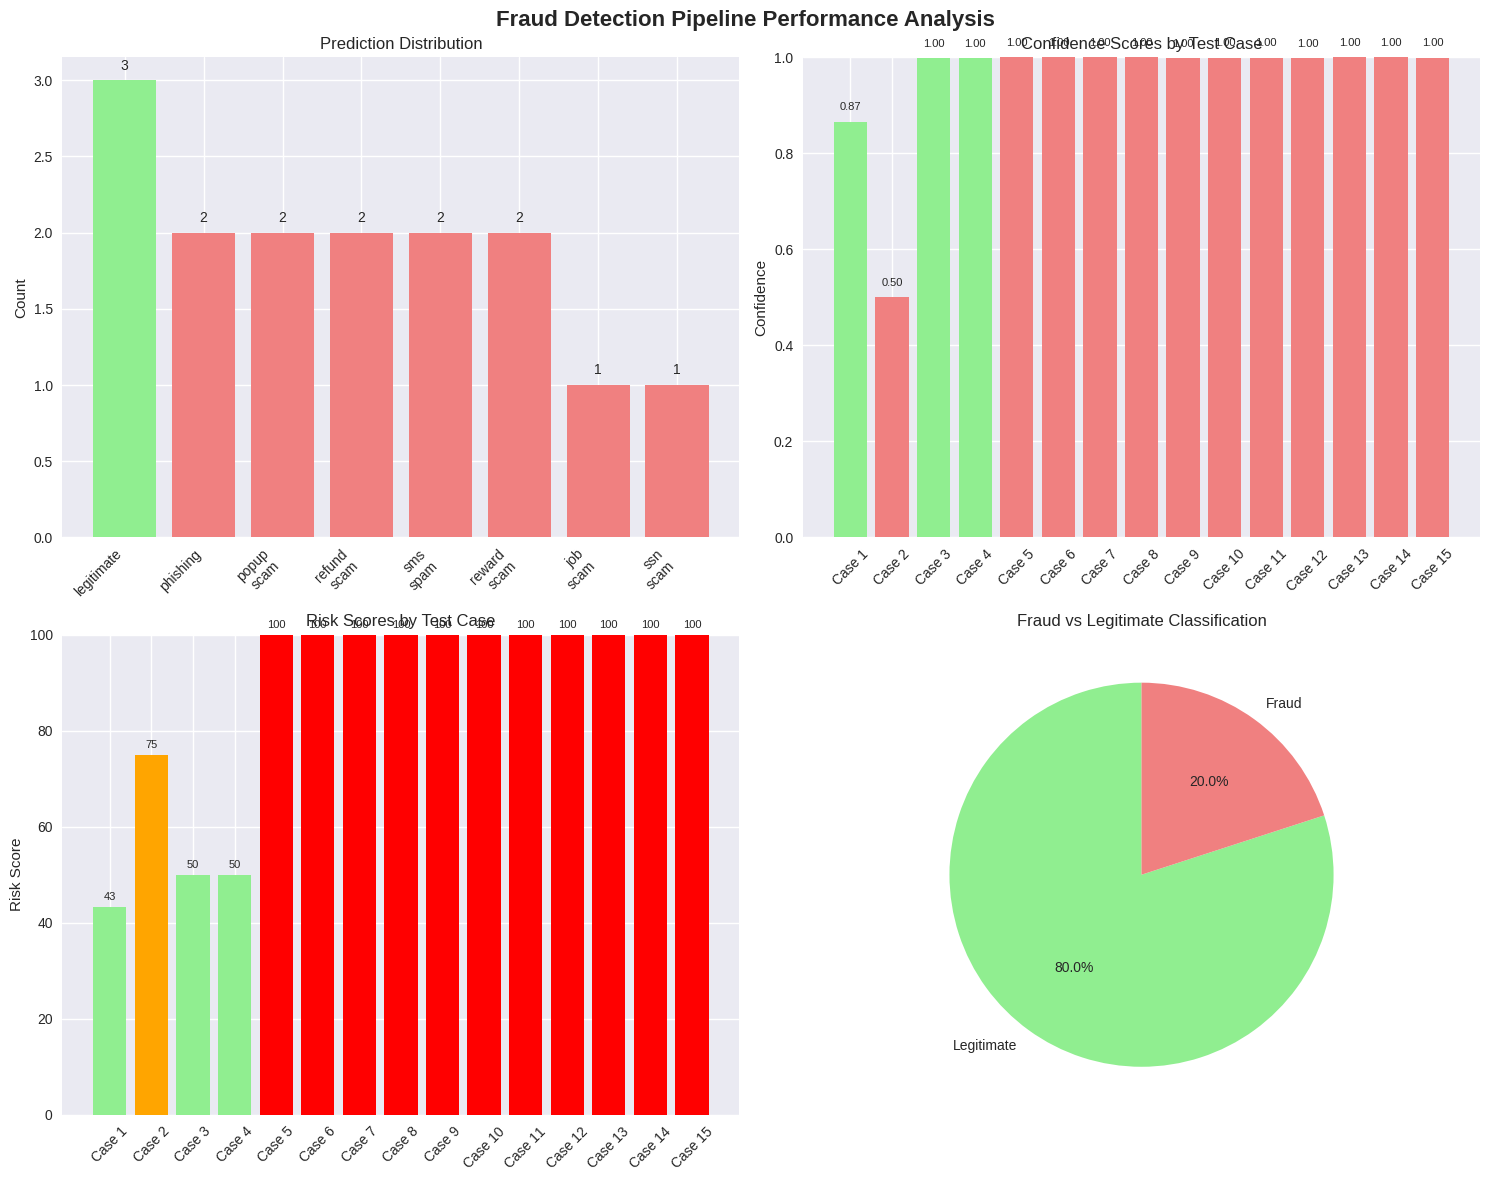

📈 Performance visualizations generated!


In [12]:
# Create performance visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Fraud Detection Pipeline Performance Analysis', fontsize=16, fontweight='bold')

# Extract data for visualization
predictions = [r['classification']['predicted_class'] for r in results]
confidences = [r['classification']['confidence'] for r in results]
risk_scores = [r['risk_score'] for r in results]
is_fraud = [r['classification']['is_fraud'] for r in results]
descriptions = [r['description'] for r in results]

# 1. Prediction Distribution
ax1 = axes[0, 0]
pred_counts = pd.Series(predictions).value_counts()
colors = ['lightgreen' if pred == 'legitimate' else 'lightcoral' for pred in pred_counts.index]
bars1 = ax1.bar(range(len(pred_counts)), pred_counts.values, color=colors)
ax1.set_xticks(range(len(pred_counts)))
ax1.set_xticklabels([p.replace('_', '\n') for p in pred_counts.index], rotation=45, ha='right')
ax1.set_title('Prediction Distribution')
ax1.set_ylabel('Count')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{int(height)}', ha='center', va='bottom')

# 2. Confidence Scores
ax2 = axes[0, 1]
colors2 = ['lightgreen' if not fraud else 'lightcoral' for fraud in is_fraud]
bars2 = ax2.bar(range(len(confidences)), confidences, color=colors2)
ax2.set_xticks(range(len(confidences)))
ax2.set_xticklabels([f'Case {i+1}' for i in range(len(confidences))], rotation=45)
ax2.set_title('Confidence Scores by Test Case')
ax2.set_ylabel('Confidence')
ax2.set_ylim(0, 1)

# Add confidence labels
for i, (bar, conf) in enumerate(zip(bars2, confidences)):
    ax2.text(bar.get_x() + bar.get_width()/2., conf + 0.02,
             f'{conf:.2f}', ha='center', va='bottom', fontsize=8)

# 3. Risk Score Distribution
ax3 = axes[1, 0]
colors3 = ['lightgreen' if score < 50 else 'orange' if score < 80 else 'red' for score in risk_scores]
bars3 = ax3.bar(range(len(risk_scores)), risk_scores, color=colors3)
ax3.set_xticks(range(len(risk_scores)))
ax3.set_xticklabels([f'Case {i+1}' for i in range(len(risk_scores))], rotation=45)
ax3.set_title('Risk Scores by Test Case')
ax3.set_ylabel('Risk Score')
ax3.set_ylim(0, 100)

# Add risk score labels
for i, (bar, score) in enumerate(zip(bars3, risk_scores)):
    ax3.text(bar.get_x() + bar.get_width()/2., score + 1,
             f'{score:.0f}', ha='center', va='bottom', fontsize=8)

# 4. Fraud vs Legitimate Classification
ax4 = axes[1, 1]
fraud_counts = pd.Series(is_fraud).value_counts()
labels = ['Legitimate', 'Fraud']
colors4 = ['lightgreen', 'lightcoral']
wedges, texts, autotexts = ax4.pie(fraud_counts.values, labels=labels, colors=colors4, 
                                   autopct='%1.1f%%', startangle=90)
ax4.set_title('Fraud vs Legitimate Classification')

plt.tight_layout()
plt.show()

print("📈 Performance visualizations generated!")

## 📋 Detailed Results Summary

In [13]:
# Create detailed results table
results_df = pd.DataFrame([
    {
        'Test Case': f"Case {i+1}",
        'Description': r['description'],
        'Expected': r['expected'],
        'Predicted': r['classification']['predicted_class'],
        'Confidence': f"{r['classification']['confidence']:.3f}",
        'Risk Score': f"{r['risk_score']:.0f}/100",
        'Fraud Indicators': len(r['fraud_indicators']),
        'Correct': r['classification']['predicted_class'] == r['expected']
    }
    for i, r in enumerate(results)
])

print("📊 DETAILED RESULTS SUMMARY")
print("=" * 120)
print(results_df.to_string(index=False))

# Calculate accuracy
accuracy = results_df['Correct'].sum() / len(results_df)
print(f"\n🎯 Overall Accuracy: {accuracy:.1%}")

# Show fraud indicator statistics
indicator_stats = results_df.groupby('Predicted')['Fraud Indicators'].agg(['mean', 'sum']).round(2)
print(f"\n🔍 Fraud Indicators by Category:")
print(indicator_stats)

print(f"\n✅ Pipeline successfully analyzed {len(test_cases)} test cases!")

📊 DETAILED RESULTS SUMMARY
Test Case                    Description    Expected   Predicted Confidence Risk Score  Fraud Indicators  Correct
   Case 1    Real dataset: job_scam case    job_scam  legitimate      0.865     43/100                 0    False
   Case 2    Real dataset: job_scam case    job_scam    job_scam      0.500     75/100                 0     True
   Case 3  Real dataset: legitimate case  legitimate  legitimate      0.998     50/100                 0     True
   Case 4  Real dataset: legitimate case  legitimate  legitimate      0.998     50/100                 0     True
   Case 5    Real dataset: phishing case    phishing    phishing      1.000    100/100                 0     True
   Case 6    Real dataset: phishing case    phishing    phishing      1.000    100/100                 0     True
   Case 7  Real dataset: popup_scam case  popup_scam  popup_scam      1.000    100/100                 0     True
   Case 8  Real dataset: popup_scam case  popup_scam  popup_s

## 🎮 Interactive Testing
Try your own text messages!

In [14]:
def interactive_analysis(text):
    """Interactive function for testing custom text"""
    if not text.strip():
        print("⚠️ Please enter some text to analyze")
        return
    
    print("\n" + "=" * 80)
    print("🔍 COMPREHENSIVE FRAUD ANALYSIS")
    print("=" * 80)
    
    result = pipeline.comprehensive_analysis(text)
    
    classification = result['classification']
    print(f"📝 Text: {text}")
    print(f"\n🎯 CLASSIFICATION RESULTS:")
    print(f"   Prediction: {classification['predicted_class'].upper()}")
    print(f"   Confidence: {classification['confidence']:.4f}")
    print(f"   Is Fraud: {'YES' if classification['is_fraud'] else 'NO'}")
    print(f"   Risk Score: {result['risk_score']:.1f}/100")
    
    if result['fraud_indicators']:
        print(f"\n🚨 FRAUD INDICATORS DETECTED:")
        for category, words in result['fraud_indicators'].items():
            print(f"   {category.title()}: {', '.join(words)}")
    else:
        print(f"\n✅ NO FRAUD INDICATORS DETECTED")
    
    print(f"\n📊 TOP PROBABILITIES:")
    sorted_probs = sorted(classification['all_probabilities'].items(), 
                        key=lambda x: x[1], reverse=True)[:3]
    for class_name, prob in sorted_probs:
        bar = "█" * int(prob * 20)
        print(f"   {class_name:20s} {prob:.4f} {bar}")
    
    print(f"\n🧠 REASONING EXPLANATION:")
    print(f"   {result['reasoning']}")
    
    return result

# Example usage - you can modify this text to test different messages
test_message = "Your account will be suspended unless you verify your information immediately by clicking this link."

print("🎮 Interactive Testing Example:")
result = interactive_analysis(test_message)



🎮 Interactive Testing Example:

🔍 COMPREHENSIVE FRAUD ANALYSIS
📝 Text: Your account will be suspended unless you verify your information immediately by clicking this link.

🎯 CLASSIFICATION RESULTS:
   Prediction: PHISHING
   Confidence: 0.9757
   Is Fraud: YES
   Risk Score: 100.0/100

🚨 FRAUD INDICATORS DETECTED:
   Urgency_Words: immediate
   Financial_Words: account
   Action_Words: click, verify
   Threat_Words: suspended

📊 TOP PROBABILITIES:
   phishing             0.9757 ███████████████████
   sms_spam             0.0183 
   legitimate           0.0057 

🧠 REASONING EXPLANATION:
   Fraudulent message with the following words: "Get all your money back."

Fraudulent Message with Alerts: An alert with this message will appear if you are not logged into your bank or credit card account. This alert will prompt you to sign in to your account first to start a new transaction. To avoi
